In [112]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.PropertyMol import PropertyMol
Chem.SetDefaultPickleProperties(Chem.PropertyPickleOptions.AllProps)
import pickle
import sys
from pathlib import Path
import matplotlib.pyplot as plt

In [113]:
sys.path.append('../recombination')
sys.path.append('../recombination/construct_ligands')
from construct_ligand import construct_ligand, read_fragment_library
from novelty import read_scaffolds

In [114]:
def pickle_loader(pickle_file):

    try:
        while True:
            yield pickle.load(pickle_file)
    except EOFError:
        pass

## All recombinations:

In [115]:
combinatorial_library_folder = Path('../CombinatorialLibrary/')
file_name = combinatorial_library_folder / 'combinatorial_library.pickle'

In [116]:
# initializations

count_ligands = 0
lipinski_ligands, filtered_ligands = 0, 0
wt_ligands = 0
logp_ligands = 0
hbd_ligands = 0
hba_ligands = 0
originals = 0
original_subs = 0
chembl_match = 0
scaffold = 0
novel = 0

subpockets = ['AP', 'FP', 'SE', 'GA', 'B1', 'B2']

n_per_sp, n_filtered_per_sp = {}, {}
for subpocket in subpockets:
    n_per_sp[subpocket] = 0
    n_filtered_per_sp[subpocket] = 0

n_sp, n_filtered_sp = {}, {}
for i in range(len(subpockets)):
    n_sp[i+1] = 0
    n_filtered_sp[i+1] = 0
    
n_atoms = {}
n_atoms_filtered = {}

In [117]:
# combining the results

with open(file_name, 'rb') as pickle_file:

    for result in pickle_loader(pickle_file):
        
            if result is None:
                continue

            count_ligands += 1

            # number of subpockets
            n_sp[result.n_subpockets] += 1
            # occupied subpockets
            for frag_id in result.meta.frag_ids:
                n_per_sp[frag_id[:2]] += 1

            # lipinski rule
            lipinski_ligands += result.lipinski
            wt_ligands += result.mwt
            logp_ligands += result.logp
            hbd_ligands += result.hbd
            hba_ligands += result.hba

            n = result.n_atoms
            # if Lipinski rule fulfilled
            if result.lipinski == 1:
                n_filtered_sp[len(result.meta.frag_ids)] += 1
                n_atoms_filtered[n] = n_atoms_filtered[n] + 1 if n in n_atoms_filtered else 1
                for frag_id in result.meta.frag_ids:
                    n_filtered_per_sp[frag_id[:2]] += 1
                filtered_ligands += 1

            # number of atoms
            n_atoms[n] = n_atoms[n] + 1 if n in n_atoms else 1
        

In [118]:
print(count_ligands)

16327604


['27.89%', '76.84%', '94.76%', '61.42%', '50.14%']


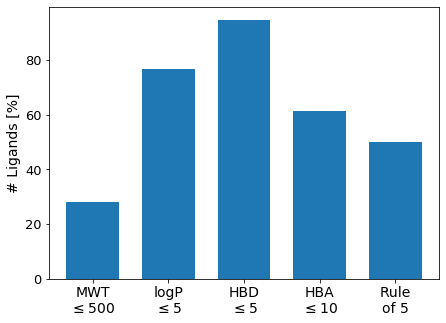

In [119]:
# plot Lipinski rule
rules = [wt_ligands/count_ligands*100, logp_ligands/count_ligands*100, hbd_ligands/count_ligands*100,
         hba_ligands/count_ligands*100, lipinski_ligands/count_ligands*100]
plt.figure(figsize=(7,5))
ax = plt.bar(range(5), rules, width=0.7)
plt.ylabel('# Ligands [%]', fontsize=14)
plt.xticks(range(5), ['MWT\n'+r'$\leq 500$', 'logP\n'+r'$\leq 5$', 'HBD\n'+r'$\leq 5$'
                      , 'HBA\n'+r'$\leq 10$', 'Rule\nof 5'], fontsize=14)
plt.yticks(fontsize=13)
#rects = ax.patches
# calculate percentages
labels = [str(round(n, 2))+'%' for n in rules]
print(labels)
#for rect, label in zip(rects, labels):
#    height = rect.get_height()
#    if height != 100 and height != 0:
#        plt.text(rect.get_x() + rect.get_width() / 2, height + 0.2, label, ha='center', va='bottom')
# plt.savefig(combinatorial_library_folder / 'lipinski.png')


['0.0%', '0.0880962081147975%', '9.2831563038888%', '90.62874748799639%', '0.0%', '0.0%']
['0.0%', '0.17334331614925702%', '16.10520656623016%', '83.72145011762059%', '0.0%', '0.0%']


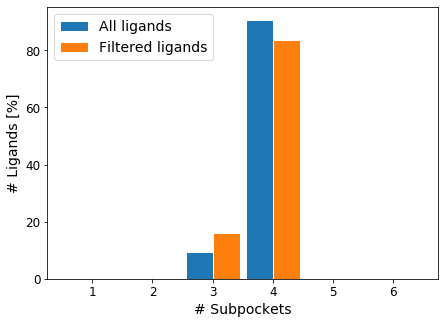

In [120]:
# plot number of subpockets per ligand
plt.figure(figsize=(7,5))
barWidth, space = 0.45, 0.2
x_values = list(map(int, n_sp.keys()))
ax1 = plt.bar(x_values, [n/count_ligands*100 for n in n_sp.values()], label='All ligands', width=barWidth, edgecolor='white')
x_values = [x+barWidth for x in list(map(int, n_filtered_sp.keys()))]
ax2 = plt.bar(x_values, [n/filtered_ligands*100 for n in n_filtered_sp.values()], label='Filtered ligands',
              width=barWidth, edgecolor='white')
plt.ylabel('# Ligands [%]', fontsize=14)
plt.xlabel('# Subpockets', fontsize=14)

rects1, rects2 = ax1.patches, ax2.patches
# calculate percentages
labels1 = [str(n/count_ligands*100)+'%' for n in n_sp.values()]
labels2 = [str(n/filtered_ligands*100)+'%' for n in n_filtered_sp.values()]
# for rect1, rect2, label1, label2 in zip(rects1, rects2, labels1, labels2):
#     height = rect1.get_height()
#     if height != 100 and height != 0:
#         plt.text(rect1.get_x() + rect1.get_width() / 2, height + 0.2, label1, fontsize=8, ha='center', va='bottom')
#     height = rect2.get_height()
#     if height != 100 and height != 0:
#         plt.text(rect2.get_x() + rect2.get_width() / 2, height + 0.2, label2, fontsize=8, ha='center', va='bottom')

plt.xticks([r + barWidth/2 for r in range(1, 7)], range(1, 7), fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='upper left', fontsize=14)
# plt.savefig(combinatorial_library_folder / 'n_subpockets.png')

print(labels1)
print(labels2)

['100.0%', '86.7%', '89.3%', '86.2%', '3.7%', '24.6%']
['100.0%', '83.9%', '89.0%', '80.7%', '3.4%', '26.5%']


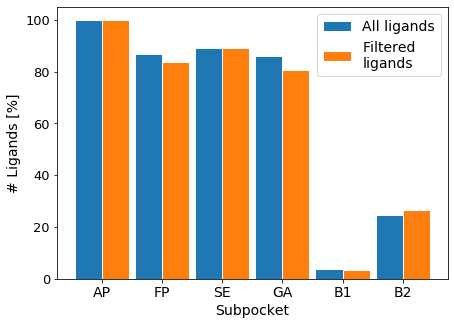

In [121]:
# plot number of fragments/ligands occupying each subpocket
plt.figure(figsize=(7,5))
barWidth, space = 0.45, 0.2
ax1 = plt.bar(range(6), [n/count_ligands*100 for n in n_per_sp.values()], label='All ligands', width=barWidth, edgecolor='white')
x_values = [x+barWidth for x in range(6)]
ax2 = plt.bar(x_values, [n/filtered_ligands*100 for n in n_filtered_per_sp.values()], label='Filtered\nligands', width=barWidth, edgecolor='white')

plt.ylabel('# Ligands [%]', fontsize=14)
plt.xlabel('Subpocket', fontsize=14)
rects1, rects2 = ax1.patches, ax2.patches
# calculate percentages
labels1 = [str(round(n/count_ligands*100, 1))+'%' for n in n_per_sp.values()]
labels2 = [str(round(n/filtered_ligands*100, 1))+'%' for n in n_filtered_per_sp.values()]
# for rect1, rect2, label1, label2 in zip(rects1, rects2, labels1, labels2):
#     height = rect1.get_height()
#     if height != 100 and height != 0:
#         plt.text(rect1.get_x() + rect1.get_width() / 2, height + 0.2, label1, fontsize=8, ha='center', va='bottom')
#     height = rect2.get_height()
#     if height != 100 and height != 0:
#         plt.text(rect2.get_x() + rect2.get_width() / 2, height + 0.2, label2, fontsize=8, ha='center', va='bottom')

plt.xticks([x + barWidth / 2 for x in range(6)], n_per_sp.keys(), fontsize=14)
plt.yticks(fontsize=13)
plt.legend(loc='upper right', fontsize=14)
# plt.savefig(combinatorial_library_folder / 'n_frags.png')

print(labels1)
print(labels2)

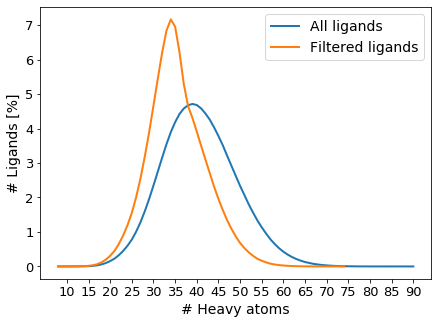

In [122]:
# plot number of atoms per ligand
plt.figure(figsize=(7,5))
x = sorted(n_atoms)
y = [n_atoms[key] for key in sorted(n_atoms)]
plt.plot(x, [n/count_ligands*100 for n in y], label='All ligands', linewidth=2)
#plt.bar(n_atoms.keys(), [n/count_ligands*100 for n in n_atoms.values()])
x = sorted(n_atoms_filtered)
y = [n_atoms_filtered[key] for key in sorted(n_atoms_filtered)]
plt.plot(x, [n/filtered_ligands*100 for n in y], label='Filtered ligands', linewidth=2)
plt.xticks(range(10, max(n_atoms)+1, 5), fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('# Heavy atoms', fontsize=14)
plt.ylabel('# Ligands [%]', fontsize=14)
plt.legend(loc='upper right', fontsize=14)
# plt.savefig(combinatorial_library_folder / 'n_atoms.png')

## Small subset:

In [123]:
combinatorial_library_folder = Path('../CombinatorialLibrary/all_subpockets_286013/')
file_name = combinatorial_library_folder / 'combinatorial_library.pickle'

In [124]:
# initializations

count_ligands = 0
lipinski_ligands, filtered_ligands = 0, 0
wt_ligands = 0
logp_ligands = 0
hbd_ligands = 0
hba_ligands = 0
originals = 0
original_subs = 0
chembl_match = 0
scaffold = 0
novel = 0

subpockets = ['AP', 'FP', 'SE', 'GA', 'B1', 'B2']

n_per_sp, n_filtered_per_sp = {}, {}
for subpocket in subpockets:
    n_per_sp[subpocket] = 0
    n_filtered_per_sp[subpocket] = 0

n_sp, n_filtered_sp = {}, {}
for i in range(len(subpockets)):
    n_sp[i+1] = 0
    n_filtered_sp[i+1] = 0
    
n_atoms = {}
n_atoms_filtered = {}

In [125]:
# combining the results

with open(file_name, 'rb') as pickle_file:

    for i, result in enumerate(pickle_loader(pickle_file)):
        
            if result is None:
                continue

            count_ligands += 1

            # number of subpockets
            n_sp[result.n_subpockets] += 1
            # occupied subpockets
            for frag_id in result.meta.frag_ids:
                n_per_sp[frag_id[:2]] += 1

            # lipinski rule
            lipinski_ligands += result.lipinski
            wt_ligands += result.mwt
            logp_ligands += result.logp
            hbd_ligands += result.hbd
            hba_ligands += result.hba

            n = result.n_atoms
            # if Lipinski rule fulfilled
            if result.lipinski == 1:
                n_filtered_sp[len(result.meta.frag_ids)] += 1
                n_atoms_filtered[n] = n_atoms_filtered[n] + 1 if n in n_atoms_filtered else 1
                for frag_id in result.meta.frag_ids:
                    n_filtered_per_sp[frag_id[:2]] += 1
                filtered_ligands += 1

            # number of atoms
            n_atoms[n] = n_atoms[n] + 1 if n in n_atoms else 1
        

In [126]:
print(count_ligands)

286013


['33.93%', '64.66%', '98.28%', '83.2%', '57.79%']


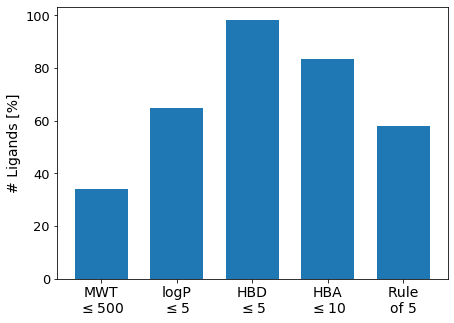

In [127]:
# plot Lipinski rule
rules = [wt_ligands/count_ligands*100, logp_ligands/count_ligands*100, hbd_ligands/count_ligands*100,
         hba_ligands/count_ligands*100, lipinski_ligands/count_ligands*100]
plt.figure(figsize=(7,5))
ax = plt.bar(range(5), rules, width=0.7)
plt.ylabel('# Ligands [%]', fontsize=14)
plt.xticks(range(5), ['MWT\n'+r'$\leq 500$', 'logP\n'+r'$\leq 5$', 'HBD\n'+r'$\leq 5$'
                      , 'HBA\n'+r'$\leq 10$', 'Rule\nof 5'], fontsize=14)
plt.yticks(fontsize=13)
#rects = ax.patches
# calculate percentages
labels = [str(round(n, 2))+'%' for n in rules]
print(labels)
#for rect, label in zip(rects, labels):
#    height = rect.get_height()
#    if height != 100 and height != 0:
#        plt.text(rect.get_x() + rect.get_width() / 2, height + 0.2, label, ha='center', va='bottom')
# plt.savefig(combinatorial_library_folder / 'lipinski.png')


['0.0%', '0.3%', '17.8%', '54.7%', '24.3%', '2.9%']
['0.0%', '0.4%', '29.8%', '61.4%', '7.9%', '0.5%']


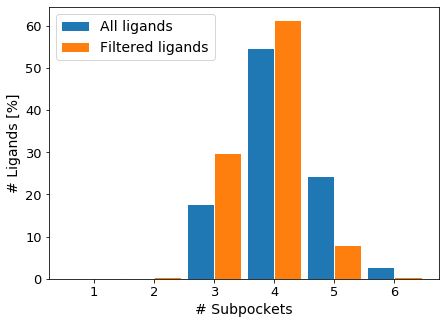

In [128]:
# plot number of subpockets per ligand
plt.figure(figsize=(7,5))
barWidth, space = 0.45, 0.2
x_values = list(map(int, n_sp.keys()))
ax1 = plt.bar(x_values, [n/count_ligands*100 for n in n_sp.values()], label='All ligands', width=barWidth, edgecolor='white')
x_values = [x+barWidth for x in list(map(int, n_filtered_sp.keys()))]
ax2 = plt.bar(x_values, [n/filtered_ligands*100 for n in n_filtered_sp.values()], label='Filtered ligands',
              width=barWidth, edgecolor='white')
plt.ylabel('# Ligands [%]', fontsize=14)
plt.xlabel('# Subpockets', fontsize=14)

rects1, rects2 = ax1.patches, ax2.patches
# calculate percentages
labels1 = [str(round(n/count_ligands*100, 1))+'%' for n in n_sp.values()]
labels2 = [str(round(n/filtered_ligands*100, 1))+'%' for n in n_filtered_sp.values()]
# for rect1, rect2, label1, label2 in zip(rects1, rects2, labels1, labels2):
#     height = rect1.get_height()
#     if height != 100 and height != 0:
#         plt.text(rect1.get_x() + rect1.get_width() / 2, height + 0.2, label1, fontsize=8, ha='center', va='bottom')
#     height = rect2.get_height()
#     if height != 100 and height != 0:
#         plt.text(rect2.get_x() + rect2.get_width() / 2, height + 0.2, label2, fontsize=8, ha='center', va='bottom')

plt.xticks([r + barWidth/2 for r in range(1, 7)], range(1, 7), fontsize=13)
plt.yticks(fontsize=13)
plt.legend(loc='upper left', fontsize=14)
# plt.savefig(combinatorial_library_folder / 'n_subpockets.png')

print(labels1)
print(labels2)

['100.0%', '56.8%', '83.7%', '82.4%', '23.8%', '65.2%']
['100.0%', '63.1%', '85.6%', '77.5%', '6.9%', '45.1%']


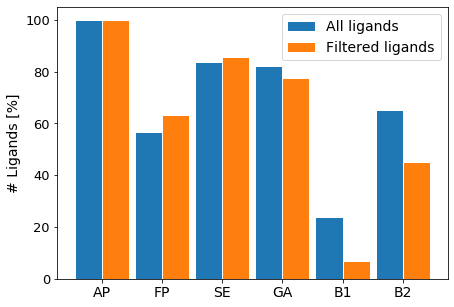

In [129]:
# plot number of fragments/ligands occupying each subpocket
plt.figure(figsize=(7,5))
barWidth, space = 0.45, 0.2
ax1 = plt.bar(range(6), [n/count_ligands*100 for n in n_per_sp.values()], label='All ligands', width=barWidth, edgecolor='white')
x_values = [x+barWidth for x in range(6)]
ax2 = plt.bar(x_values, [n/filtered_ligands*100 for n in n_filtered_per_sp.values()], label='Filtered ligands', width=barWidth, edgecolor='white')

plt.ylabel('# Ligands [%]', fontsize=14)
rects1, rects2 = ax1.patches, ax2.patches
# calculate percentages
labels1 = [str(round(n/count_ligands*100, 1))+'%' for n in n_per_sp.values()]
labels2 = [str(round(n/filtered_ligands*100, 1))+'%' for n in n_filtered_per_sp.values()]
# for rect1, rect2, label1, label2 in zip(rects1, rects2, labels1, labels2):
#     height = rect1.get_height()
#     if height != 100 and height != 0:
#         plt.text(rect1.get_x() + rect1.get_width() / 2, height + 0.2, label1, fontsize=8, ha='center', va='bottom')
#     height = rect2.get_height()
#     if height != 100 and height != 0:
#         plt.text(rect2.get_x() + rect2.get_width() / 2, height + 0.2, label2, fontsize=8, ha='center', va='bottom')

plt.xticks([x + barWidth / 2 for x in range(6)], n_per_sp.keys(), fontsize=14)
plt.yticks(fontsize=13)
plt.legend(loc='upper right', fontsize=14)
# plt.savefig(combinatorial_library_folder / 'n_frags.png')

print(labels1)
print(labels2)

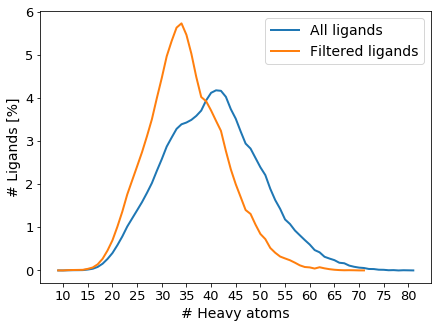

In [130]:
# plot number of atoms per ligand
plt.figure(figsize=(7,5))
x = sorted(n_atoms)
y = [n_atoms[key] for key in sorted(n_atoms)]
plt.plot(x, [n/count_ligands*100 for n in y], label='All ligands', linewidth=2)
#plt.bar(n_atoms.keys(), [n/count_ligands*100 for n in n_atoms.values()])
x = sorted(n_atoms_filtered)
y = [n_atoms_filtered[key] for key in sorted(n_atoms_filtered)]
plt.plot(x, [n/filtered_ligands*100 for n in y], label='Filtered ligands', linewidth=2)
plt.xticks(range(10, max(n_atoms)+1, 5), fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('# Heavy atoms', fontsize=14)
plt.ylabel('# Ligands [%]', fontsize=14)
plt.legend(loc='upper right', fontsize=14)
# plt.savefig(combinatorial_library_folder / 'n_atoms.png')